In [1]:
try:
    from tqdm import tqdm
except ImportError:
    def tqdm(iterator, *args, **kwargs):
        return iterator
import os, sys, glob, warnings, glob    
import numpy as np
import scipy as sp
from scipy import constants
from pylab import *
import joblib
import importlib
from importlib import reload
sys.path.append("/home/owhgabri/My_GitHub/MATHUSLA_JupyterNoteBooks/tracker")
sys.path.insert(1, "/home/owhgabri/My_GitHub/MATHUSLA_JupyterNoteBooks/tracker")
os.chdir('/home/owhgabri/My_GitHub/pyTracker')
print(os.getcwd())
print(joblib.__version__)

/home/owhgabri/My_GitHub/pyTracker
1.4.2


In [2]:
import scipy
import copy as cp

# ROOT
import ROOT as root

# Matplotlib
import matplotlib.pyplot as plt
from matplotlib import collections, colors, transforms

%matplotlib inline
%config InlineBackend.figure_format='retina'
# %matplotlib widget

import pprint

Welcome to JupyROOT 6.26/14


In [3]:
import kalmanfilter as KF
import utilities as Util
import trackfinder as TF
import vertexfinder as VF
import datatypes
from datatypes import *

reload(TF)
reload(VF)
reload(Util)

<module 'utilities' from '/home/owhgabri/My_GitHub/MATHUSLA_JupyterNoteBooks/tracker/utilities.py'>

### Defining Useful Functions ### 

In [4]:
steel_height=3 # cm
Box_IP_Depth=8547 # cm   
c = 29.979 # cm/ns


wall_floor1 = (7000,8633.2)
wall_floor2 = (7000,8551.6)
wallMid1 = 6896.6
wallMid2 = 6998.2
floorMid1 = 8550.8
floorMid2 = 8632.4

IP = (0,0,0)

y_bottoms = [8550, 8631.6]
z_fronts = [6895.8, 6997.4]
x_lims = (-1950, 1950)
thickness = 1.6

In [10]:
def SortByTime(points):
    """
    Sorts list hits by time
    A hit is of the form (x,y,z,t)
    """
    if len(points) <= 1:
        return points
    pivot = points[len(points) // 2]
    left = []
    middle = []
    right = []
    for point in points:
        if point[-1] < pivot[-1]:
            left.append(point)
        elif point[-1] > pivot[-1]:
            right.append(point)
        elif point[-1] == pivot[-1]:
            middle.append(point)
    return SortByTime(left) + middle + SortByTime(right)


def GoingUp(points):
    """
    Takes a sorted list of points and check if it is going up.
    If it is, return True
    """
    for i in range(1, len(points)):
        if points[i-1][1] > points[i][1]:
            return False
    return True


def IP_track_cov(hit):
    """
    Construct the covariance of an "IP track" connecting from IP to a given hit
    Two points:
    IP: [0, 0, 0, t-dt], Hit: [x, y, z, t] 
    Returns the covariance of the tracklet
    Covariance will be of the form (x,y,z,Ax,Ay,Az)
    Refer to journal/report for explanation
    """
    x,y,z,t = (hit.x, hit.y, hit.z, hit.t)
    err = (hit.x_err, hit.y_err, hit.z_err, hit.t_err)
    dt= np.linalg.norm((x,y,z))/c
    dt3c2 = dt**3 * c**2
    
    # tracklet Jacobian #
    # dependent on the definition of the tracklet #
    jac = np.array([[1, 0, 0, 0],
                    [0, 1, 0, 0],
                    [0, 0, 1, 0],
                    [0, 0, 0, 1],
                    [1/dt - x**2/dt3c2, -x*y/dt3c2, -x*z/dt3c2, 0],
                    [-x*y/dt3c2, 1/dt - y**2/dt3c2, -z*y/dt3c2, 0],
                    [-x*z/dt3c2, -z*y/dt3c2, 1/dt - z**2/dt3c2, 0]])
    
    track_cov = jac @ np.diag(np.array(err)**2) @ jac.T
    return track_cov   


def MakeTracklet(hit):
    """
    Create a track from a hit in the floor/wall
    Assuming two points:
    IP: [0, 0, 0, t-dt], Hit: [x, y, z, t] 
    Returns a Track including covariance.
    No chi2, ind, hits, or hits_filtered included
    """
    x,y,z,t = (hit.x, hit.y, hit.z, hit.t)
    err = (hit.x_err, hit.y_err, hit.z_err, hit.t_err)
    cov = IP_track_cov(hit)
    dt = np.linalg.norm((x,y,z))/c
    Ax = x/dt; Ay = y/dt; Az = z/dt; At = 1
    # Ax = x/t; Ay = y/t; Az = z/t
    tracklet = datatypes.Track(x,y,z,t,Ax,Ay,Az,At,cov,0,0,[],[])
    return tracklet

    
def TrackMinimumTime(track, tracklet):
    """
    Get the time at which the distance between
    track1 and track2 is minimum
    track2 is the tracklet. It's velocities are parametrized by time
    """
    if track.Ay == 1: # Horizontal track
        Ax1 = track.Ax/track.At; Ay1 = 1/track.At; Az1 = track.Az/track.At
    elif track.Az == 1: # Vertical track
        Ax1 = track.Ax/track.At; Ay1 = track.Ay/track.At; Az1 = 1/track.At
    A1 = np.array((Ax1, Ay1, Az1))
    point1 = np.array((track.x0, track.y0, track.z0))
    
    Ax2 = tracklet.Ax; Ay2 = tracklet.Ay; Az2 = tracklet.Az
    A2 = np.array((Ax2, Ay2, Az2))
    point2 = np.array((tracklet.x0, tracklet.y0, tracklet.z0))
    
    A_diff = A1 - A2
    P_diff = point1 - point2
    return (-np.dot(A_diff, P_diff) + np.dot(A_diff, A1*track.t0 - A2*tracklet.t0))/np.dot(A_diff, A_diff)
        
    
def TrackDistance(track1, tracklet, minTime):
    """
    Get the distance between the track and tracklet at minTime
    """
    if track1.Ay == 1: # Horizontal track
        Ax1 = track1.Ax/track1.At; Ay1 = 1/track1.At; Az1 = track1.Az/track1.At
    elif track.Az == 1: # Vertical track
        Ax1 = track.Ax/track.At; Ay1 = track.Ay/track.At; Az1 = 1/track.At
    track1Point = np.array((track.x0 + Ax1*(minTime - track.t0), 
                           track.y0 + Ay1*(minTime - track.t0),
                           track.z0 + Az1*(minTime - track.t0)))
    trackletPoint = np.array((tracklet.x0 + tracklet.Ax*(minTime - tracklet.t0),
                             tracklet.y0 + tracklet.Ay*(minTime - tracklet.t0),
                             tracklet.z0 + tracklet.Az*(minTime - tracklet.t0)))
    return np.linalg.norm(track1Point - trackletPoint)


def TrackMidpoint(track1, tracklet, minTime):
    """
    Get the distance between the track and tracklet at minTime
    """
    if track1.Ay == 1: # Horizontal track
        Ax1 = track1.Ax/track1.At; Ay1 = 1/track1.At; Az1 = track1.Az/track1.At
    elif track.Az == 1: # Vertical track
        Ax1 = track1.Ax/track1.At; Ay1 = track1.Ay/track1.At; Az1 = 1/track1.At
    track1Point = np.array((track1.x0 + Ax1*(minTime - track1.t0), 
                           track1.y0 + Ay1*(minTime - track1.t0),
                           track1.z0 + Az1*(minTime - track1.t0)))
    trackletPoint = np.array((tracklet.x0 + tracklet.Ax*(minTime - tracklet.t0),
                             tracklet.y0 + tracklet.Ay*(minTime - tracklet.t0),
                             tracklet.z0 + tracklet.Az*(minTime - tracklet.t0)))
    return (track1Point + trackletPoint)/ 2

    
def TrackletProjectionPoint(tracklet, t):
    """
    Get the projection (x,y,z) of the tracklet at time t
    """
    return np.array((tracklet.x0 + tracklet.Ax*(t-tracklet.t0),
                    tracklet.y0 + tracklet.Ay*(t-tracklet.t0),
                    tracklet.z0 + tracklet.Az*(t-tracklet.t0)))
    

def TrackletProjectionCovariance(tracklet, t):
    """
    Get the projected covariance of the tracklet at time t
    Covariance for tracklets is of the form (x,y,z,Ax,Ay,Az)
    where A's are already with respect to time
    """
    x0,y0,z0,t0 = (tracklet.x0, tracklet.y0, tracklet.z0, tracklet.t0)
    jac = np.array([[1, 0, 0, t-t0, 0, 0],
                    [0, 1, 0, 0, t-t0, 0],
                    [0, 0, 1, 0, 0, t-t0]])
    # jac = np.array([[1, 0, 0, t, 0, 0],
    #                 [0, 1, 0, 0, t, 0],
    #                 [0, 0, 1, 0, 0, t]])
    return jac@track.cov@jac.T


def ProjectionTime(track, points, layer):
    """
    Takes a track and its SORTED list of points
    closest is true if you want to check in the closest wall/floor,
    false if you wanna check in the farther wall/floor
    Returns the time at which the track is 
    projected to enter the wall or floor
    Given point is (x,y,z,t)
    """
    if layer == 0:# Walls
        if track.Ay == 1: # Horizontal layer track 
            return track.At/track.Az*(wallMid1 - points[0][2]) + points[0][3]
        else: # Vertical layer track
            return track.At*(wallMid1 - points[0][2]) + points[0][3]
    elif layer == 1:
        if track.Ay == 1: # Horizontal layer track
            return track.At/track.Az*(wallMid2 - points[0][2]) + points[0][3]
        else: # Vertical layer track
            return track.At*(wallMid2 - points[0][2]) + points[0][3]
    elif layer == 2: # Floors
        if track.Ay == 1: # Horizontal layer track
            return track.At*(floorMid1 - points[0][1]) + points[0][3]
        else: # Vertical layer track
            return track.At/track.Ay*(floorMid1 - points[0][1]) + points[0][3]
    elif layer == 3: 
        if track.Ay == 1: # Horizontal layer track
            return track.At*(floorMid2 - points[0][1]) + points[0][3]
        else: # Vertical layer track
            return track.At/track.Ay*(floorMid2 - points[0][1]) + points[0][3]


def ProjectionPoint(track, points, t):
    """
    Returns where the track is projected to be at time t.
    points is the list of hits from the track sorted by time
    Returns an empty array if out of the detector
    """
    if track.Ay == 1: #Horizontal layer track
        xf = points[0][0] + track.Ax/track.At*(t - points[0][3])
        yf = points[0][1] + 1/track.At * (t - points[0][3])
        zf = points[0][2] + track.Az/track.At*(t - points[0][3])
    else: # Vertical layer track 
        xf = points[0][0] + track.Ax/track.At*(t - points[0][3])
        yf = points[0][1] + track.Ay/track.At * (t - points[0][3])
        zf = points[0][2] + 1/track.At*(t - points[0][3])
    return np.array((xf,yf,zf))


def ProjectionCovariance(track, points, t):
    """
    Returns the projected covariance of x,y,z at time t.
    covariance is x,z,t,Ax,Az,At if horizontal track, or 
    x,y,t,Ax,Ay,At if vertical track.
    points is sorted by time
    """
    dt = t - points[0][3]
    if track.Ay == 1: # Horizontal track
        Jac = np.array([[1, 0, -track.Ax/track.At, dt/track.At, 0, -track.Ax*dt/track.At**2],
                        [0, 0, -1/track.At, 0, 0, -dt/track.At**2],
                        [0, 1, -track.Az/track.At, 0, dt/track.At, -track.Az*dt/track.At**2]])
    elif track.Az == 1: # Vertical Track 
        Jac = np.array([[1, 0, -track.Ax/track.At, dt/track.At, 0, -track.Ax*dt/track.At**2],
                        [0, 1, -track.Ay/track.At, 0, dt/track.At, -track.Ay*dt/track.At**2],
                        [0, 0, -1/track.At, 0, 0, -dt/track.At**2]])    
    return Jac@track.cov@Jac.T


def GetChiSquared(track, tracklet):
    """
    Get the chi squared between a track and a tracklet
    """
    TrackPoints = SortByTime(track.hits_filtered)
    minTime = TrackMinimumTime(track, tracklet)
    midpoint = TrackMidpoint(track, tracklet, minTime)

    track_point_proj = ProjectionPoint(track, TrackPoints, minTime)
    tracklet_point_proj = TrackletProjectionPoint(tracklet, minTime)

    tracklet_cov_proj = TrackletProjectionCovariance(tracklet, minTime)
    track_cov_proj = ProjectionCovariance(track, TrackPoints, minTime)
    try:
        inv_tracklet_cov = np.linalg.inv(tracklet_cov_proj)
        inv_track_cov = np.linalg.inv(track_cov_proj)
    except:
        return None

    track_res = track_point_proj - midpoint
    tracklet_res = tracklet_point_proj - midpoint
    tracklet_chi2 = tracklet_res.T @ inv_tracklet_cov @ tracklet_res
    track_chi2 = track_res.T @ inv_track_cov @ track_res

    chi2 = tracklet_chi2 + track_chi2
    return chi2


def GetDistance(point1, point2):
    """
    Get the distance between two points (x,y,z)
    """
    return np.sqrt((point1[0]-point2[0])**2 + (point1[1]-point2[1])**2 + (point1[2]-point2[2])**2)




In [11]:
data_top_dir = f"/home/owhgabri/My_GitHub/data/Reconstruction/10xCosmicBackground"
pathList=[]

for rootFile, dirs, files in os.walk(data_top_dir):
    for filename in files:
        if ".pkl" in filename:
            pathList.append(os.path.join(rootFile, filename))


print(len(pathList))

98


### Checking Tracklet Projection ###

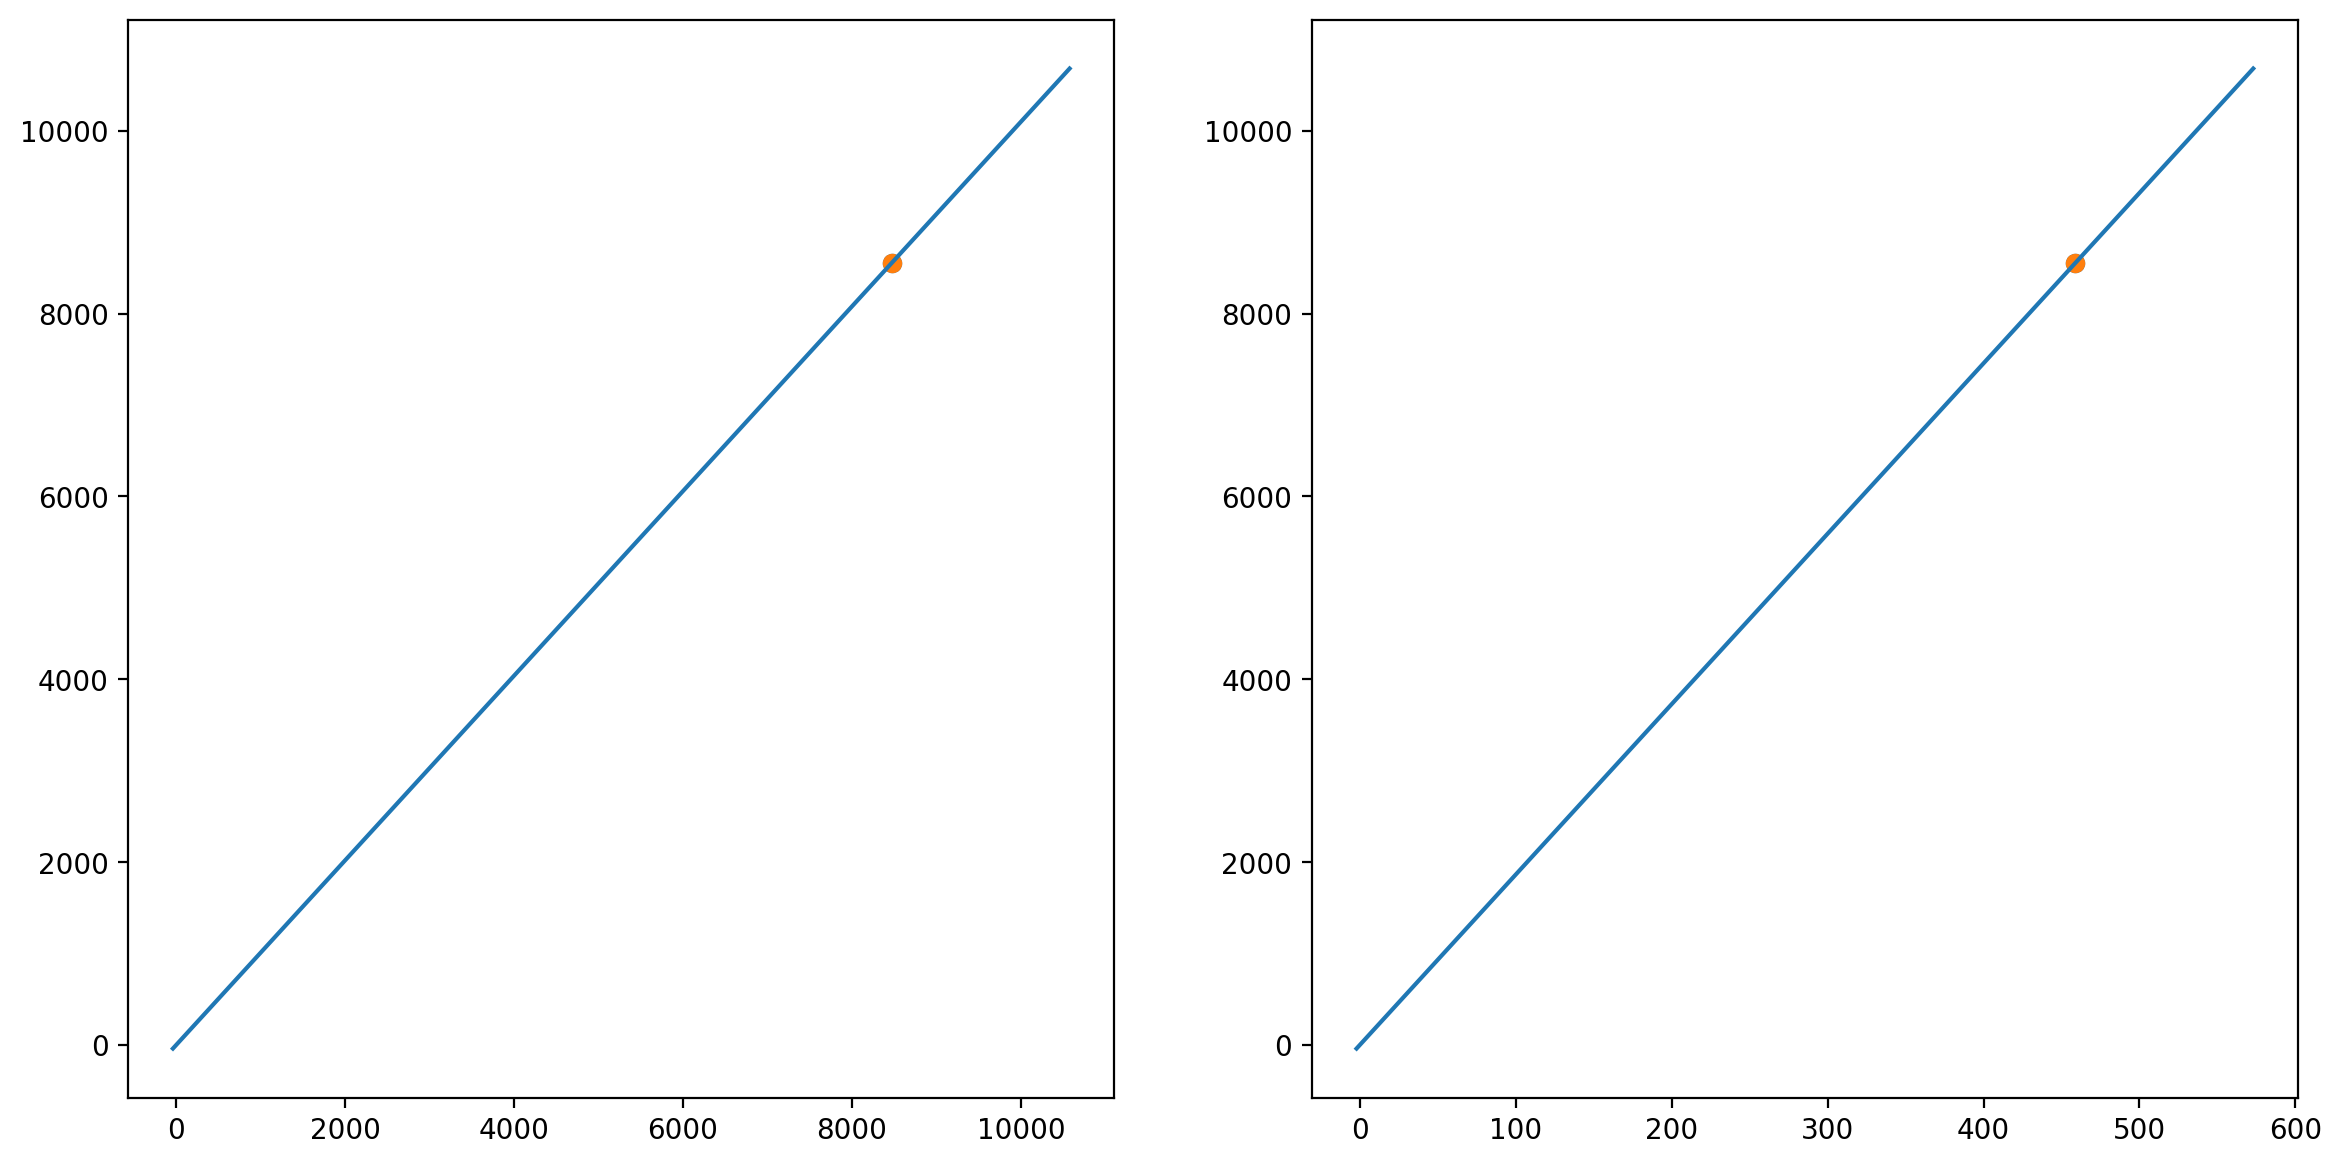

In [12]:
fig,axs=plt.subplots(1,2,figsize=(14,7))
axs=axs.flatten().tolist()

events=joblib.load(pathList[0])
file_hits = events["hits"]
file_tracks = events["tracks"]
file_vertices = events["vertices"]
i = 30
searching = True
while searching:
    i+= 1
    hits= file_hits[i]
    tracks = file_tracks[i]
    vertices = file_vertices[i]
    if len(tracks) < 1:
        continue
    wf_hits = []
    for hit in hits:
        if hit.layer < 4:
            wf_hits.append(hit)
    for hit in wf_hits:
        tracklet = MakeTracklet(hit)
        times = np.linspace(0, hit.t + 100, 300)
        points = TrackletProjectionPoint(tracklet, times)
        axs[0].scatter(hit.z, hit.y, label="real point")
        axs[1].scatter(hit.x, hit.y)
        axs[0].scatter(tracklet.z0, tracklet.y0, label="tracklet point")
        axs[1].scatter(tracklet.x0, tracklet.y0)
        axs[0].plot(points[2], points[1])
        axs[1].plot(points[0], points[1])
        break
    searching = False

### Checking Individual Track ###

Random Tracklet: 1060.1330783537226 8550.8 7312.75
Tracklet Values: 1060.1330783537226 8550.8 7312.75
Random Tracklet: 1089.75 8632.4 7370.036627271285
Tracklet Values: 1089.75 8632.4 7370.036627271285
Random Tracklet: -1817.25 8632.400000000001 8596.930862194858
Random Tracklet: -521.25 8632.400000000001 7710.1423149812035
Random Tracklet: 783.75 8632.400000000001 8386.466470861342
Random Tracklet: 706.5463883588757 8550.8 10350.25
Tracklet Values: 706.5463883588757 8550.8 10350.25
Random Tracklet: 695.141599720537 8550.8 10354.75
Tracklet Values: 695.141599720537 8550.8 10354.75
Random Tracklet: 707.25 8632.4 10448.237432506705
Tracklet Values: 707.25 8632.4 10448.237432506705
Random Tracklet: -1737.314717285335 9377.25 6896.6
Random Tracklet: -846.6243034112267 8550.8 7587.25
Random Tracklet: -903.75 8632.4 8396.151786159411
Tracklet Values: -903.75 8632.4 8396.151786159411
Random Tracklet: -834.101320239186 8550.8 8379.25
Tracklet Values: -834.101320239186 8550.8 8379.25
Random Tra

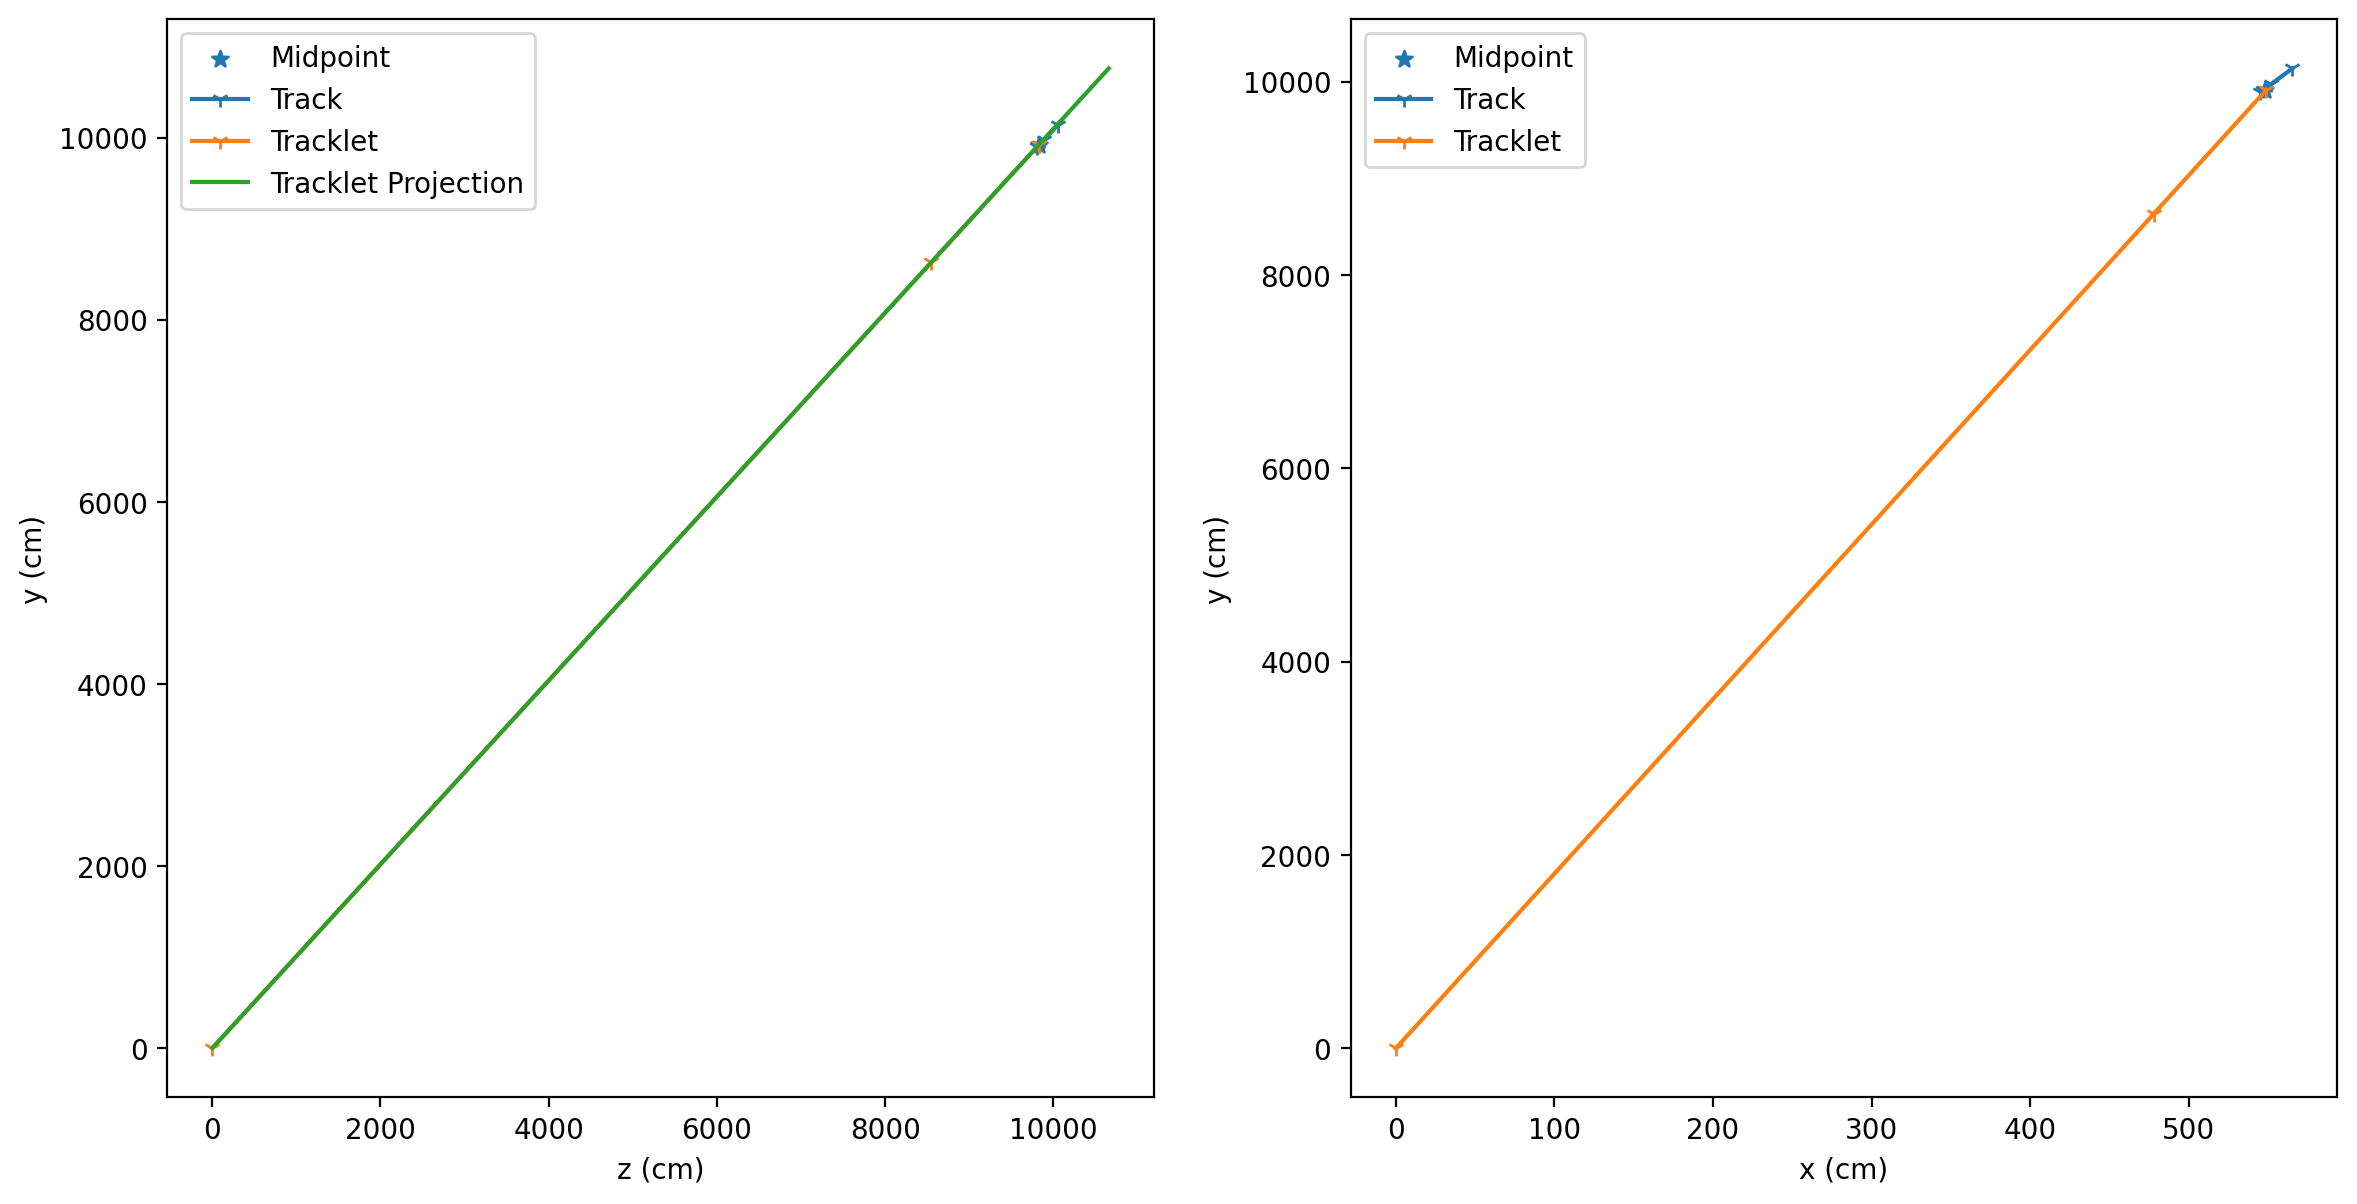

In [15]:
fig,axs=plt.subplots(1,2,figsize=(14,7))
axs=axs.flatten().tolist()

events=joblib.load(pathList[0])
file_hits = events["hits"]
file_tracks = events["tracks"]
file_vertices = events["vertices"]
i = 13
searching = True
while searching:
    i+= 1
    hits= file_hits[i]
    tracks = file_tracks[i]
    vertices = file_vertices[i]
    if len(tracks) < 1:
        continue
    wf_hits = []
    for hit in hits:
        if hit.layer < 4:
            wf_hits.append(hit)
    for track in tracks:
        trackPoints = SortByTime(track.hits_filtered)
        if not GoingUp(trackPoints):
            continue
        chi2 = 9999999999999
        min_hit = None
        min_time = None
        min_tracklet = None
        for hit in wf_hits:
            tracklet = MakeTracklet(hit)
            cur_chi2 = GetChiSquared(track, tracklet)
            print("Random Tracklet:", tracklet.x0, tracklet.y0, tracklet.z0)
            if cur_chi2 is not None and cur_chi2 < chi2 and cur_chi2 > 0:
                chi2 = cur_chi2
                min_tracklet = tracklet
                print("Tracklet Values:", min_tracklet.x0, min_tracklet.y0, min_tracklet.z0)
                min_time = TrackMinimumTime(track, min_tracklet)
                min_point_track = ProjectionPoint(track, trackPoints, min_time)
                min_point_tracklet = TrackletProjectionPoint(min_tracklet, min_time)
                midpoint = TrackMidpoint(track, min_tracklet, min_time)
                times = np.linspace(0, hit.t + 100, 300)
                points = TrackletProjectionPoint(min_tracklet, times)
        if min_time is None or (chi2 > 0 and chi2 < 50):
            searching = False
            print("Tracklet Values After:", min_tracklet.x0, min_tracklet.y0, min_tracklet.z0)
            x,y,z = np.array(track.hits_filtered).T[:3]
            x = np.append(x, min_point_track[0])
            y = np.append(y, min_point_track[1])
            z = np.append(z, min_point_track[2])
            xl,yl,zl = np.array((min_tracklet.x0, min_tracklet.y0, min_tracklet.z0))
            xl = np.append(xl, min_point_tracklet[0])
            yl = np.append(yl, min_point_tracklet[1])
            zl = np.append(zl, min_point_tracklet[2])
            xl = np.insert(xl, 0, 0)
            yl = np.insert(yl, 0, 0)
            zl = np.insert(zl, 0, 0)
            x_h,y_h,z_h = np.array([midpoint[0], midpoint[1], midpoint[2]])
            axs[0].set_xlabel("z (cm)")
            axs[0].set_ylabel("y (cm)")
            axs[0].scatter(z_h, y_h, marker="*", label="Midpoint")
            axs[0].plot(z,y, marker="1", label="Track")
            axs[0].plot(zl,yl, marker="1", label="Tracklet")
            axs[0].plot(points[2],points[1], label="Tracklet Projection")
            axs[1].set_xlabel("x (cm)")
            axs[1].set_ylabel("y (cm)")
            axs[1].scatter(x_h, y_h, marker="*", label="Midpoint")
            axs[1].plot(x,y,marker="1", label="Track")
            axs[1].plot(xl,yl,marker="1",label="Tracklet")
            axs[0].legend()
            axs[1].legend()
            print("index:", i)
            print("midpoint:", (x_h, y_h, z_h))
            print("chi2:", chi2)
            print("Ax:", min_tracklet.Ax)
            print("Ay:", min_tracklet.Ay)
            print("Az:", min_tracklet.Az)
            print("min_time:", min_time)
            print("tracklet start:", (min_tracklet.x0, min_tracklet.y0, min_tracklet.z0, min_tracklet.t0))
            print("track start:", (track.x0, track.y0, track.z0, track.t0))
            print("tracklet projection:", (xl[-1],yl[-1],zl[-1]))
            break